### EDA (eda.py)

In [44]:
import os
import random

import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
train_df = pd.read_csv('../data/train.csv')
meta_df = pd.read_csv('../data/meta.csv')
df = train_df.merge(meta_df, on='target', how='left')

print("Train shape:", train_df.shape)
print("Meta shape:", meta_df.shape)
df.head()

Train shape: (1570, 2)
Meta shape: (17, 2)


,ID,target,class_name
0,002f99746285dfdd.jpg,16,vehicle_registration_plate
1,008ccd231e1fea5d.jpg,10,payment_confirmation
2,008f5911bfda7695.jpg,10,payment_confirmation
3,009235e4c9c07af5.jpg,4,diagnosis
4,00b2f44967580c74.jpg,16,vehicle_registration_plate


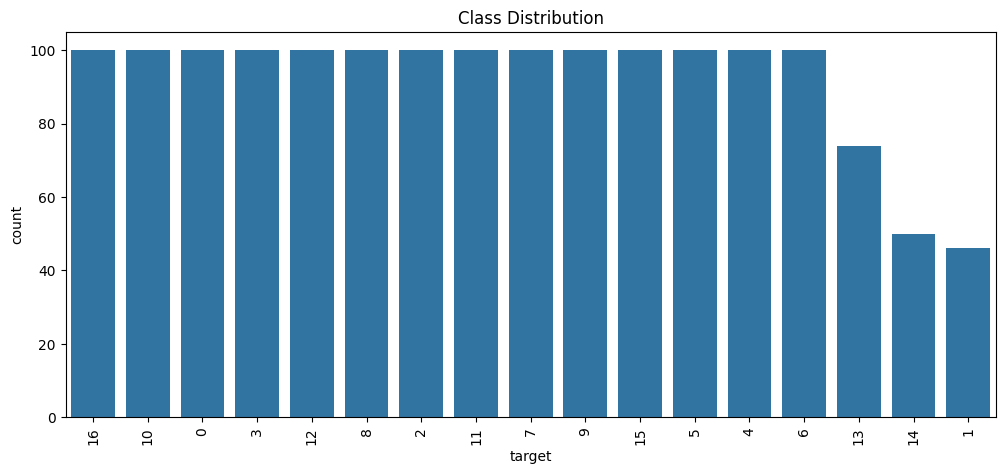

In [46]:
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x="target", order=df['target'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.show()

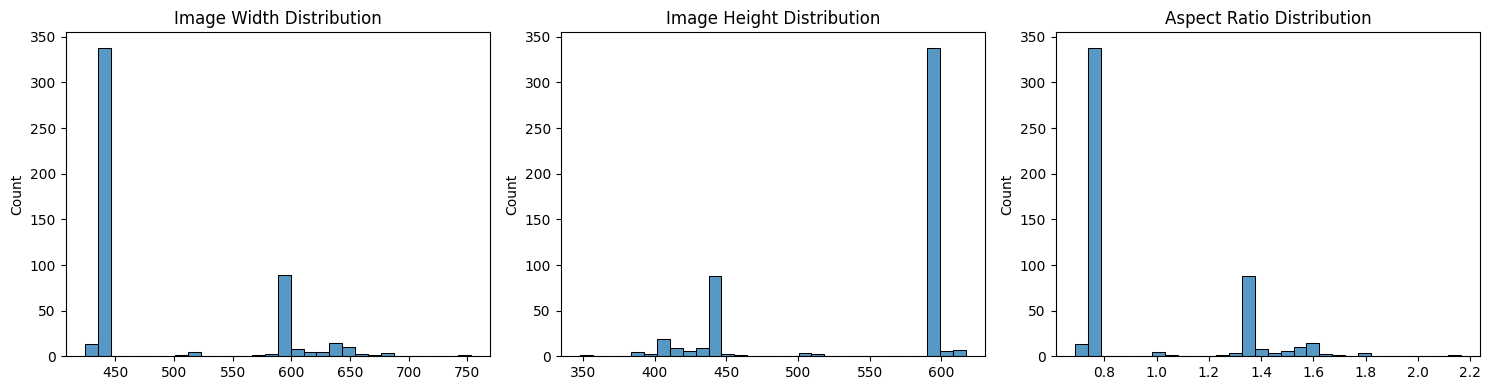

In [47]:
IMG_DIR = "../data/train"
heights, widths, ratios = [], [], []

for img_id in df["ID"].sample(500, random_state=42):  # 샘플만
    path = os.path.join(IMG_DIR, f"{img_id}")
    img = cv2.imread(path)
    if img is not None:
        h, w = img.shape[:2]
        heights.append(h)
        widths.append(w)
        ratios.append(w / h)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
sns.histplot(widths, bins=30)
plt.title("Image Width Distribution")

plt.subplot(1, 3, 2)
sns.histplot(heights, bins=30)
plt.title("Image Height Distribution")

plt.subplot(1, 3, 3)
sns.histplot(ratios, bins=30)
plt.title("Aspect Ratio Distribution")

plt.tight_layout()
plt.show()


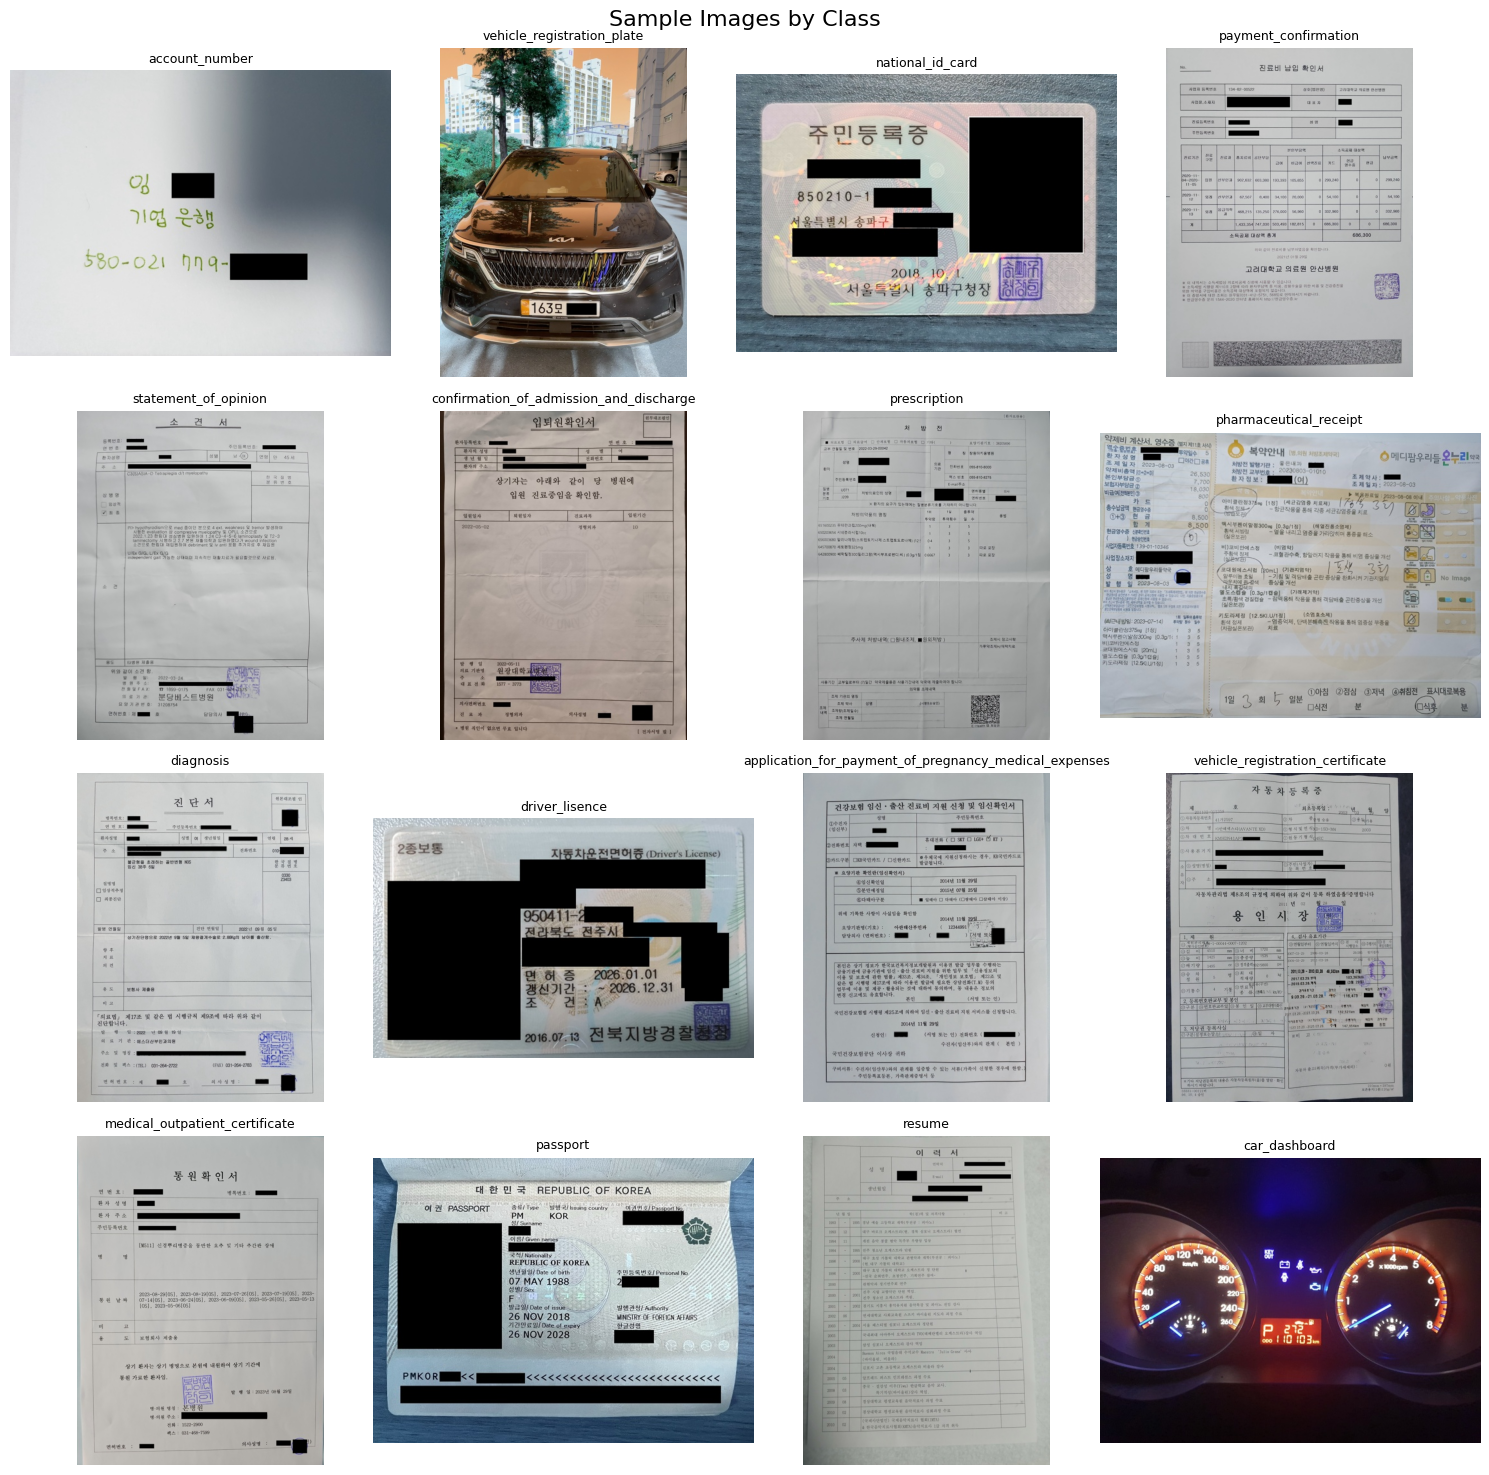

In [48]:
unique_labels = df["target"].unique()
plt.figure(figsize=(15, 15))
for i, label in enumerate(random.sample(list(unique_labels), 16)):
    sample_id = df[df["target"] == label].sample(1, random_state=42)["ID"].values[0]
    path = os.path.join(IMG_DIR, f"{sample_id}")
    img = cv2.imread(path)[:, :, ::-1]  # BGR -> RGB

    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(meta_df.iloc[label].class_name, fontsize=9)
    plt.axis("off")
plt.suptitle("Sample Images by Class", fontsize=16)
plt.tight_layout()
plt.show()

### 데이터셋 & 증강 (dataset.py)

In [ ]:
import os

import cv2
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset

In [50]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def get_transforms(img_size=384, is_train=True):
    base_resize = [
        A.LongestMaxSize(max_size=img_size, interpolation=cv2.INTER_AREA),
        A.PadIfNeeded(min_height=img_size, min_width=img_size,
            border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]),
    ]

    if is_train:
        aug_safe = [
            A.Affine(scale=(0.95, 1.05),
                     rotate=(-8, 8),
                     shear={'x':(-4, 4), 'y':(-4, 4)},
                     translate_percent={'x':(-0.03, 0.03), 'y':(-0.03, 0.03)},
                     p=0.7),
            A.Perspective(scale=(0.02, 0.05), keep_size=True, p=0.3),
            A.ImageCompression(quality_lower=60, quality_upper=95, p=0.5),
            A.Downscale(scale_min=0.9, scale_max=0.98, p=0.3),
            A.GaussianBlur(blur_limit=(3, 5), p=0.2),
            A.GaussNoise(var_limit=(5.0, 15.0), p=0.2),
            A.RandomBrightnessContrast(brightness_limit=0.12, contrast_limit=0.12, p=0.5),
            A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, val_shift_limit=10, p=0.2),
            A.RandomResizedCrop(height=img_size, width=img_size, scale=(0.90, 1.0), ratio=(0.95, 1.05), p=0.15),
        ]
        
        tail = [
            A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ToTensorV2(),
        ]

        return A.Compose(base_resize + aug_safe + tail)

    else:
        return A.Compose(
            base_resize + [
                A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
                ToTensorV2(),
            ]
        )

In [51]:
class DocDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['ID'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)['image']
        
        if self.is_test:
            return image, row['ID']
        else:
            target = int(row['target'])
            return image, target

### 학습 스크립트 (train_kfold.py)

In [52]:
import os
import gc
import json

import numpy as np
import pandas as pd
import timm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# from dataset import DocDataset, get_transforms

In [53]:
SEED = 42
IMG_SIZE = 384
BATCH_SIZE = 16
EPOCHS_HEAD = 5
EPOCHS_FULL = 15
FOLDS = 5
MODEL_NAME = 'convnext_tiny'
NUM_WORKERS = 4

DATA_DIR = '../data'
TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'train')
TRAIN_CSV = os.path.join(DATA_DIR, 'train.csv')
META_CSV = os.path.join(DATA_DIR, 'meta.csv')
OUT_DIR = '../results'
os.makedirs(OUT_DIR, exist_ok=True)

def set_seed(seed=SEED):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [54]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=1.5, weight=None):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)
    def forward(self, logits, targets):
        logp = nn.functional.log_softmax(logits, dim=1)
        ce = nn.functional.nll_loss(logp, targets, weight=self.ce.weight, reduction='none')
        p = torch.exp(-ce)
        loss = ((1-p) ** self.gamma) * ce
        return loss.mean()

In [55]:
def build_model(num_classes):
    model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=num_classes)
    return model

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    losses = []
    all_preds, all_targets = [], []
    for imgs, targets in tqdm(loader, leave=False):
        imgs, targets = imgs.to(device), targets.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        all_preds.extend(logits.detach().softmax(1).cpu().numpy().argmax(1))
        all_targets.extend(targets.cpu().numpy())
    f1 = f1_score(all_targets, all_preds, average='macro')
    return np.mean(losses), f1

@torch.no_grad()
def valid_one_epoch(model, loader, criterion, device):
    model.eval()
    losses = []
    all_preds, all_targets = [], []
    for imgs, targets in loader:
        imgs, targets = imgs.to(device), targets.to(device)
        logits = model(imgs)
        loss = criterion(logits, targets)
        losses.append(loss.item())
        all_preds.extend(logits.softmax(1).cpu().numpy().argmax(1))
        all_targets.extend(targets.cpu().numpy())
    f1 = f1_score(all_targets, all_preds, average='macro')
    return np.mean(losses), f1

def get_class_weights(train_df, num_classes):
    counts = train_df['target'].value_counts().reindex(range(num_classes), fill_value=0).values.astype(np.float32)
    w = counts.sum() / (counts + 1e-6)
    w = w / w.mean()
    return torch.tensor(w, dtype=torch.float)

In [56]:
def main():
    set_seed()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_df = pd.read_csv(TRAIN_CSV)
    meta_df = pd.read_csv(META_CSV)
    num_classes = train_df['target'].nunique()

    tf_train = get_transforms(IMG_SIZE, is_train=True)
    tf_valid = get_transforms(IMG_SIZE, is_train=False)

    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    oof_preds = np.zeros((len(train_df), num_classes), dtype=np.float32)
    oof_targets = train_df['target'].values

    class_weight = get_class_weights(train_df, num_classes).to(device)

    for fold, (tr_idx, va_idx) in enumerate(skf.split(train_df, train_df['target'])):
        print(f'\n=============== Fold {fold} ===============')
        tr_df = train_df.iloc[tr_idx].reset_index(drop=True)
        va_df = train_df.iloc[va_idx].reset_index(drop=True)

        sample_weights = class_weight.detach().cpu().numpy()[tr_df['target'].values]
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

        tr_ds = DocDataset(tr_df, TRAIN_IMG_DIR, transform=tf_train, is_test=False)
        va_ds = DocDataset(va_df, TRAIN_IMG_DIR, transform=tf_valid, is_test=False)

        tr_loader = DataLoader(tr_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True)
        va_loader = DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

        model = build_model(num_classes).to(device)

        for n, p in model.named_parameters():
            p.requires_grad = ('head' in n) or ('fc' in n) or ('classifier' in n)
        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4, weight_decay=1e-4)
        criterion = FocalLoss(gamma=1.5, weight=class_weight)

        best_f1, best_path = -1, os.path.join(OUT_DIR, f'{MODEL_NAME}_fold{fold}.pt')

        for epoch in range(1, EPOCHS_HEAD+1):
            tr_loss, tr_f1 = train_one_epoch(model, tr_loader, optimizer, criterion, device)
            va_loss, va_f1 = valid_one_epoch(model, va_loader, criterion, device)
            print(f'[Head][{epoch}/{EPOCHS_HEAD}] tr_loss:{tr_loss:.4f} tr_f1:{tr_f1:.4f} | va_loss:{va_loss:.4f} va_f1:{va_f1:.4f}')
            if va_f1 > best_f1:
                best_f1 = va_f1
                torch.save(model.state_dict(), best_path)

        for p in model.parameters(): p.requires_grad = True
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

        patience, patience_cnt = 4, 0
        for epoch in range(1, EPOCHS_FULL+1):
            tr_loss, tr_f1 = train_one_epoch(model, tr_loader, optimizer, criterion, device)
            va_loss, va_f1 = valid_one_epoch(model, va_loader, criterion, device)
            print(f'[Full][{epoch}/{EPOCHS_FULL}] tr_loss:{tr_loss:.4f} tr_f1:{tr_f1:.4f} | va_loss:{va_loss:.4f} va_f1:{va_f1:.4f}')
            if va_f1 > best_f1:
                best_f1 = va_f1
                torch.save(model.state_dict(), best_path)
                patience_cnt = 0
            else:
                patience_cnt += 1
                if patience_cnt >= patience:
                    print('Early stopping!')
                    break

        model.load_state_dict(torch.load(best_path, map_location=device))
        model.eval()
        va_loader = DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
        preds = []
        with torch.no_grad():
            for imgs, targets in va_loader:
                imgs = imgs.to(device, non_blocking=True)
                logits = model(imgs).softmax(1).cpu().numpy()
                preds.append(logits)
        preds = np.concatenate(preds, axis=0)
        oof_preds[va_idx] = preds

        print(f'Fold {fold} best Macro-F1: {best_f1:.4f}')

        del model, tr_ds, va_ds, tr_loader, va_loader, preds
        gc.collect(); torch.cuda.empty_cache()

    oof_labels = oof_preds.argmax(1)
    oof_f1 = f1_score(oof_targets, oof_labels, average='macro')
    print(f'\nOOF Macro-F1: {oof_f1:.4f}')
    np.save(os.path.join(OUT_DIR, f'{MODEL_NAME}_oof_probs.npy'), oof_preds)

# if __name__ == '__main__':
#     main()

In [57]:
main()

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1692: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(



=============== Fold 0 ===============


  0%|          | 0/79 [00:00<?, ?it/s]

[Head][1/5] tr_loss:2.4152 tr_f1:0.0958 | va_loss:1.4365 va_f1:0.1970


[Head][2/5] tr_loss:1.0406 tr_f1:0.4724 | va_loss:0.6605 va_f1:0.6151


[Head][3/5] tr_loss:0.6007 tr_f1:0.6641 | va_loss:0.3998 va_f1:0.7266


[Head][4/5] tr_loss:0.3986 tr_f1:0.7503 | va_loss:0.3616 va_f1:0.7309


[Head][5/5] tr_loss:0.2862 tr_f1:0.8263 | va_loss:0.2860 va_f1:0.7743


[Full][1/15] tr_loss:0.2350 tr_f1:0.8514 | va_loss:0.2259 va_f1:0.8009


[Full][2/15] tr_loss:0.1732 tr_f1:0.8882 | va_loss:0.2616 va_f1:0.8680


[Full][3/15] tr_loss:0.1249 tr_f1:0.9108 | va_loss:0.1531 va_f1:0.8683


[Full][4/15] tr_loss:0.1232 tr_f1:0.9108 | va_loss:0.1588 va_f1:0.8747


[Full][5/15] tr_loss:0.0986 tr_f1:0.9101 | va_loss:0.1738 va_f1:0.8674


[Full][6/15] tr_loss:0.0869 tr_f1:0.9306 | va_loss:0.2038 va_f1:0.8439


[Full][7/15] tr_loss:0.0951 tr_f1:0.9290 | va_loss:0.1564 va_f1:0.8834


KeyboardInterrupt: 

### 추론 스크립트 (inference.py)

In [90]:
import os
import glob

import timm
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

# from dataset import DocDataset, get_transforms

In [92]:
IMG_SIZE = 384
BATCH_SIZE = 32
MODEL_NAME = 'convnext_tiny'
NUM_WORKERS = 4

DATA_DIR = '../data'
TEST_IMG_DIR = os.path.join(DATA_DIR, 'test')
SUBMIT_PATH = f'../results/{MODEL_NAME}.csv'

WEIGHTS_GLOB = f'../results/{MODEL_NAME}_fold*.pt'

In [93]:
def build_model(num_classes):
    model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=num_classes)
    return model

@torch.no_grad()
def main():
    meta_df = pd.read_csv(os.path.join(DATA_DIR, 'meta.csv'))
    num_classes = meta_df['target'].nunique()

    test_ids = sorted([f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
    test_df = pd.DataFrame({'ID': test_ids})

    tf_test = get_transforms(IMG_SIZE, is_train=False)
    ds = DocDataset(test_df, TEST_IMG_DIR, transform=tf_test, is_test=True)
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    weight_paths = sorted(glob.glob(WEIGHTS_GLOB))
    assert len(weight_paths) > 0, '가중치(.pt) 파일을 찾을 수 없습니다.'

    logits_sum = None
    for w in weight_paths:
        model = build_model(num_classes).to(device)
        model.load_state_dict(torch.load(w, map_location=device))
        model.eval()

        fold_logits = []
        for imgs, ids in loader:
            imgs = imgs.to(device)
            logit = model(imgs).detach().cpu().numpy()
            fold_logits.append(logit)
        fold_logits = np.concatenate(fold_logits, axis=0)

        if logits_sum is None:
            logits_sum = fold_logits
        else:
            logits_sum += fold_logits

        del model

    probs = torch.tensor(logits_sum / len(weight_paths)).softmax(1).numpy()
    preds = probs.argmax(1)

    sub = pd.DataFrame({'ID': test_df['ID'], 'target': preds})
    sub.to_csv(SUBMIT_PATH, index=False)
    print(f'Saved: {SUBMIT_PATH}')

# if __name__ == '__main__':
#     main()

In [94]:
main()

Saved: ../results/convnext_tiny.csv
